In [2]:
# so modules are automatically reloaded when they are changed
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from utils.results_utils import *
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn

from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from scipy.stats import linregress
from matplotlib.patches import Patch


In [5]:
def parse_auc_std(column):
    aucs = []
    stds = []
    for entry in column:
        if type(entry) == float:
            if np.isnan(entry):
                aucs.append(np.nan)
                stds.append(np.nan)
        else:
            try:
                auc, std = entry.split(" ± ")
                aucs.append(float(auc))
                stds.append(float(std))
            except ValueError or AttributeError:
                # Handle unexpected formats
                aucs.append(np.nan)
                stds.append(np.nan)
    return np.array(aucs), np.array(stds)

# Overall test results

## gDRO and resampling

In [4]:
mnist_df = pd.read_csv('processed_results/mnist_overall_auc_gdro_resampling.csv')
mnist_df.set_index('Subgroup', inplace=True)
mnist_baseline_df = mnist_df.loc['baseline']
mnist_df = mnist_df.drop(['noisy_AY_001', 'noisy_AY_005','noisy_AY_010','noisy_AY_025','baseline'])
cxp_df = pd.read_csv('processed_results/cxp_overall_auc_gdro_resampling.csv')
cxp_df.set_index('Subgroup', inplace=True)
cxp_baseline_df = cxp_df.loc['baseline']
cxp_df = cxp_df.drop(['noisy_AY_001', 'noisy_AY_005','noisy_AY_010','noisy_AY_025','baseline'])
mnist_df = mnist_df.rename(index={"Artefact": "A"})
mnist_df = mnist_df.rename(index={"Sex": "S"})
mnist_df = mnist_df.rename(index={"Majority": "SC/no-SC"})
mnist_df = mnist_df.rename(index={"noisy_AY_050": "Noisy_AY_0.5"})

cxp_df = cxp_df.rename(index={"Artefact": "A"})
cxp_df = cxp_df.rename(index={"Sex": "S"})
cxp_df = cxp_df.rename(index={"Majority": "SC/no-SC"})
cxp_df = cxp_df.rename(index={"noisy_AY_050": "Noisy_AY_0.5"})


mnist_df.sort_values(by='gDRO', ascending=False, inplace=True)
cxp_df = cxp_df.loc[mnist_df.index]

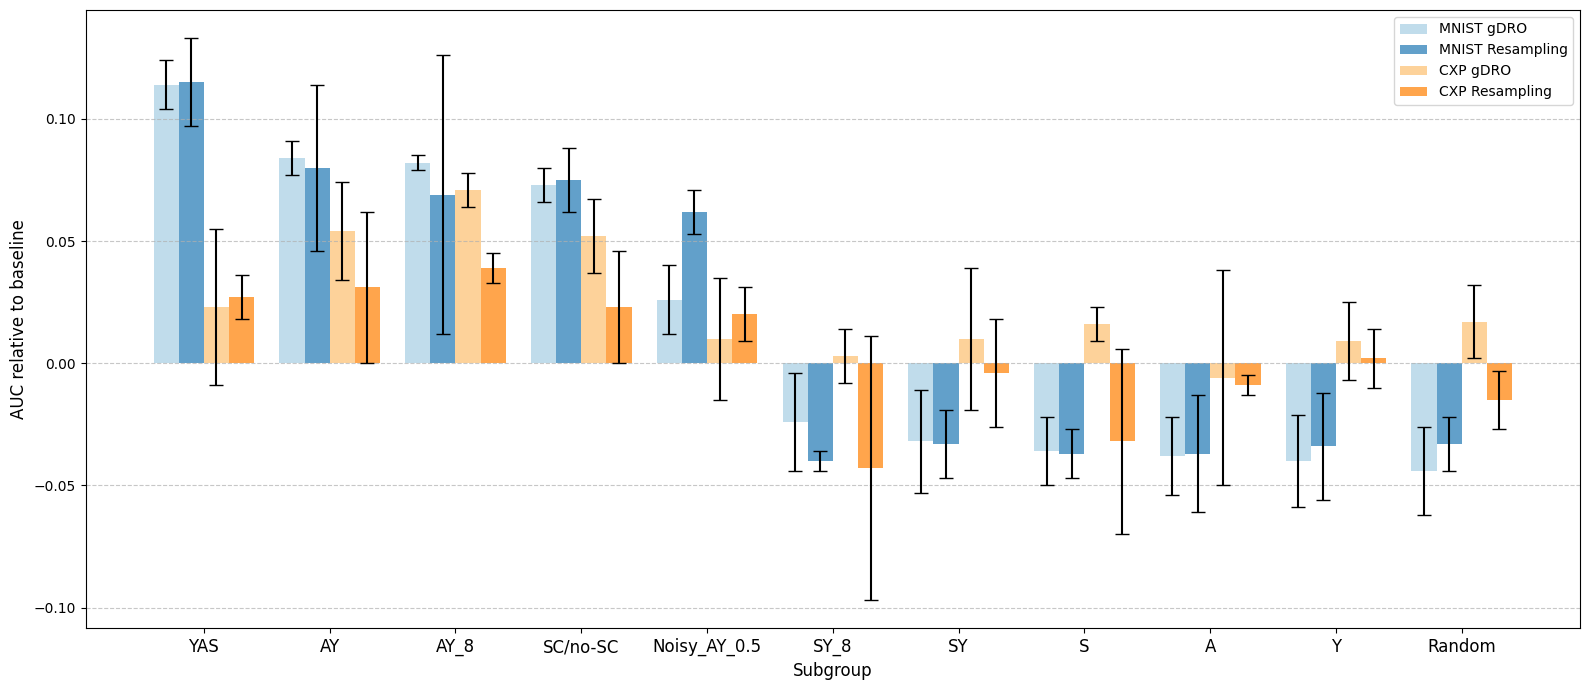

In [6]:
# Parse data
subgroups = mnist_df.index
mnist_gDRO_aucs, mnist_gDRO_stds = parse_auc_std(mnist_df["gDRO"])
mnist_resampling_aucs, mnist_resampling_stds = parse_auc_std(mnist_df["Resampling"])
cxp_gDRO_aucs, cxp_gDRO_stds = parse_auc_std(cxp_df["gDRO"])
cxp_resampling_aucs, cxp_resampling_stds = parse_auc_std(cxp_df["Resampling"])

# Extract baseline AUCs
mnist_baseline_auc = parse_auc_std(mnist_baseline_df)[0][0]
cxp_baseline_auc = parse_auc_std(cxp_baseline_df)[0][0]

mnist_gDRO_aucs = mnist_gDRO_aucs - mnist_baseline_auc
mnist_resampling_aucs = mnist_resampling_aucs - mnist_baseline_auc
cxp_gDRO_aucs = cxp_gDRO_aucs - cxp_baseline_auc
cxp_resampling_aucs = cxp_resampling_aucs - cxp_baseline_auc

colors = sns.color_palette("Paired")

mnist_gDRO_color = colors[0] 
mnist_resampling_color = colors[1]
cxp_gDRO_color = colors[6]
cxp_resampling_color = colors[7]

x = np.arange(len(subgroups))  # the label locations
width = 0.2

fig, ax = plt.subplots(figsize=(16, 7))
ax.bar(
    x - width, mnist_gDRO_aucs, width, yerr=mnist_gDRO_stds,
    label="MNIST gDRO", color=mnist_gDRO_color, alpha=0.7, capsize=5
)
ax.bar(
    x, mnist_resampling_aucs, width, yerr=mnist_resampling_stds,
    label="MNIST Resampling", color=mnist_resampling_color, alpha=0.7, capsize=5
)
ax.bar(
    x + width, cxp_gDRO_aucs, width, yerr=cxp_gDRO_stds,
    label="CXP gDRO", color=cxp_gDRO_color, alpha=0.7, capsize=5
)
ax.bar(
    x + 2 * width, cxp_resampling_aucs, width, yerr=cxp_resampling_stds,
    label="CXP Resampling", color=cxp_resampling_color, alpha=0.7, capsize=5
)
ax.set_xlabel("Subgroup", fontsize=12)
ax.set_ylabel("AUC relative to baseline", fontsize=12)
ax.set_xticks(x + width / 2)  # Center subgroup labels
ax.set_xticklabels(subgroups, rotation=0, fontsize=12)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## DomainInd and CFair

In [9]:
mnist_df = pd.read_csv('processed_results/mnist_overall_auc_domainind_cfair.csv')
# drop rows where subgroup is 'noisy_AY_001' or 'noisy_AY_005'
mnist_df.set_index('Subgroup', inplace=True)
mnist_baseline_df = mnist_df.loc['baseline']
mnist_df = mnist_df.drop(['noisy_A_001', 'noisy_A_005','noisy_A_010','noisy_A_025','baseline'])
cxp_df = pd.read_csv('processed_results/cxp_overall_auc_domainind_cfair.csv')
cxp_df.set_index('Subgroup', inplace=True)
cxp_baseline_df = cxp_df.loc['baseline']
cxp_df = cxp_df.drop(['noisy_A_001', 'noisy_A_005','noisy_A_010','noisy_A_025','baseline'])
mnist_df = mnist_df.rename(index={"Artefact": "A"})
mnist_df = mnist_df.rename(index={"Sex": "S"})
mnist_df = mnist_df.rename(index={"Majority": "SC/no-SC"})
mnist_df = mnist_df.rename(index={"noisy_A_050": "Noisy_A_0.5"})

cxp_df = cxp_df.rename(index={"Artefact": "A"})
cxp_df = cxp_df.rename(index={"Sex": "S"})
cxp_df = cxp_df.rename(index={"Majority": "SC/no-SC"})
cxp_df = cxp_df.rename(index={"noisy_A_050": "Noisy_A_0.5"})

cxp_df.sort_values(by='DomainInd', ascending=False, inplace=True)
mnist_df = mnist_df.loc[cxp_df.index]

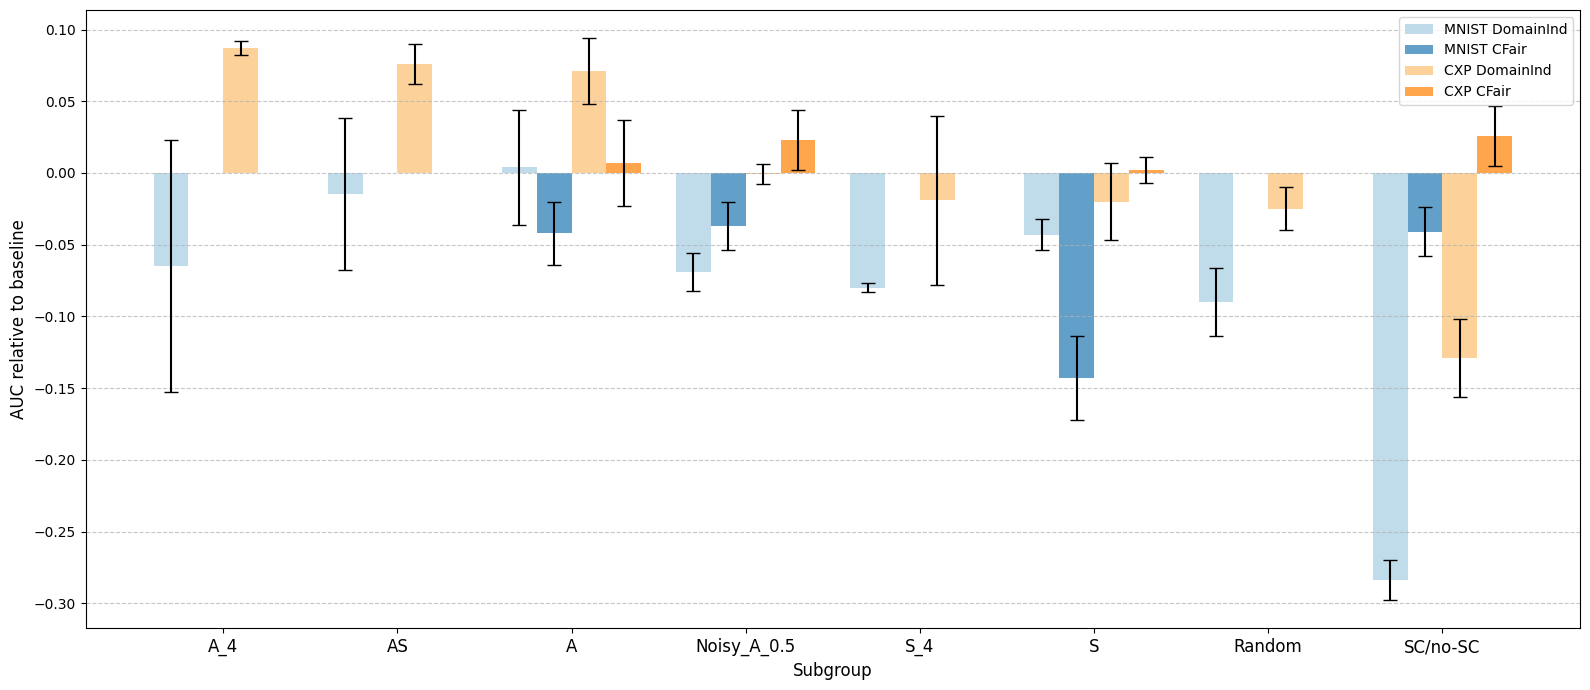

In [10]:
subgroups = mnist_df.index
mnist_gDRO_aucs, mnist_gDRO_stds = parse_auc_std(mnist_df["DomainInd"])
mnist_resampling_aucs, mnist_resampling_stds = parse_auc_std(mnist_df["CFair"])
cxp_gDRO_aucs, cxp_gDRO_stds = parse_auc_std(cxp_df["DomainInd"])
cxp_resampling_aucs, cxp_resampling_stds = parse_auc_std(cxp_df["CFair"])

# Extract baseline AUCs
mnist_baseline_auc = parse_auc_std(mnist_baseline_df)[0][0]
cxp_baseline_auc = parse_auc_std(cxp_baseline_df)[0][0]

mnist_gDRO_aucs = mnist_gDRO_aucs - mnist_baseline_auc
mnist_resampling_aucs = mnist_resampling_aucs - mnist_baseline_auc
cxp_gDRO_aucs = cxp_gDRO_aucs - cxp_baseline_auc
cxp_resampling_aucs = cxp_resampling_aucs - cxp_baseline_auc

colors = sns.color_palette("Paired")

# Assign colors
mnist_gDRO_color = colors[0]
mnist_resampling_color = colors[1]
cxp_gDRO_color = colors[6]
cxp_resampling_color = colors[7]

x = np.arange(len(subgroups))  # the label locations
width = 0.2

fig, ax = plt.subplots(figsize=(16, 7))
ax.bar(
    x - width, mnist_gDRO_aucs, width, yerr=mnist_gDRO_stds,
    label="MNIST DomainInd", color=mnist_gDRO_color, alpha=0.7, capsize=5
)
ax.bar(
    x, mnist_resampling_aucs, width, yerr=mnist_resampling_stds,
    label="MNIST CFair", color=mnist_resampling_color, alpha=0.7, capsize=5
)
ax.bar(
    x + width, cxp_gDRO_aucs, width, yerr=cxp_gDRO_stds,
    label="CXP DomainInd", color=cxp_gDRO_color, alpha=0.7, capsize=5
)
ax.bar(
    x + 2 * width, cxp_resampling_aucs, width, yerr=cxp_resampling_stds,
    label="CXP CFair", color=cxp_resampling_color, alpha=0.7, capsize=5
)
ax.set_xlabel("Subgroup", fontsize=12)
ax.set_ylabel("AUC relative to baseline", fontsize=12)
ax.set_xticks(x + width / 2)  # Center subgroup labels
ax.set_xticklabels(subgroups, rotation=0, fontsize=12)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Disparities

## S disparities

In [40]:
mnist_mean_df = pd.read_csv('processed_results/mnist_gdro_resampling_s_acc.csv', index_col=0)
cxp_mean_df = pd.read_csv('processed_results/cxp_gdro_resampling_s_acc.csv', index_col=0)

mnist_std_df = pd.read_csv('processed_results/mnist_gdro_resampling_s_acc_std.csv', index_col=0)
cxp_std_df = pd.read_csv('processed_results/cxp_gdro_resampling_s_acc_std.csv', index_col=0)

mnist_formatted = mnist_mean_df.round(3).astype(str) + " ± " + mnist_std_df.round(3).astype(str)
cxp_formatted = cxp_mean_df.round(3).astype(str) + " ± " + cxp_std_df.round(3).astype(str)

merged_df = pd.concat([mnist_formatted, cxp_formatted], axis=1)

# Define new hierarchical column names
datasets = ["MNIST"] * 4 + ["CXP"] * 4
methods = ["gDRO", "gDRO", "Resampling", "Resampling"] * 2
merged_df.columns = pd.MultiIndex.from_tuples(zip(datasets, methods, merged_df.columns))

merged_df

MNIST                                               \
                       gDRO                    Resampling                  
                    min Acc        Acc gap      min Acc.1      Acc gap.1   
baseline      0.599 ± 0.061  0.194 ± 0.112  0.599 ± 0.061  0.194 ± 0.079   
SY            0.574 ± 0.023   0.226 ± 0.04  0.583 ± 0.029  0.188 ± 0.032   
AY            0.782 ± 0.018  0.022 ± 0.038  0.744 ± 0.057  0.085 ± 0.058   
Artefact       0.58 ± 0.015   0.192 ± 0.03  0.578 ± 0.023  0.193 ± 0.032   
AY_8           0.78 ± 0.009  0.014 ± 0.027  0.731 ± 0.097  0.095 ± 0.098   
Sex           0.575 ± 0.017  0.211 ± 0.028  0.579 ± 0.017  0.187 ± 0.026   
SY_8          0.588 ± 0.025  0.209 ± 0.031   0.575 ± 0.01  0.185 ± 0.013   
Y             0.577 ± 0.019   0.21 ± 0.027  0.578 ± 0.026   0.199 ± 0.03   
noisy_AY_001  0.771 ± 0.005  0.035 ± 0.022  0.735 ± 0.056  0.093 ± 0.057   
noisy_AY_005  0.768 ± 0.011  0.041 ± 0.028  0.759 ± 0.035  0.084 ± 0.037   
noisy_AY_010    0.76 ± 0.01  0.048 ± 0.033  0.686 ± 0.023   0.148 ± 0.03   
noisy_AY_025  0.754 ± 0.018  0.042 ± 0.035  0.752 ± 0.021  0.089 ± 0.022   
noisy_AY_050  0.686 ± 0.029  0.111 ± 0.059  0.695 ± 0.013  0.143 ± 0.017   
Random         0.579 ± 0.02  0.193 ± 0.037  0.584 ± 0.025  0.185 ± 0.028   
Majority      0.749 ± 0.024  0.046 ± 0.053   0.74 ± 0.034  0.082 ± 0.035   
YAS           0.817 ± 0.019  0.014 ± 0.024  0.819 ± 0.021   0.03 ± 0.026   

                        CXP                                               
                       gDRO                    Resampling                 
                    min Acc        Acc gap      min Acc.1      Acc gap.1  
baseline       0.633 ± 0.02  0.051 ± 0.026   0.633 ± 0.02  0.051 ± 0.026  
SY            0.645 ± 0.029    0.06 ± 0.03  0.624 ± 0.009   0.061 ± 0.02  
AY            0.698 ± 0.017  0.051 ± 0.032  0.655 ± 0.028  0.065 ± 0.042  
Artefact      0.632 ± 0.027  0.077 ± 0.064  0.629 ± 0.007  0.079 ± 0.024  
AY_8          0.675 ± 0.006  0.101 ± 0.027  0.675 ± 0.025  0.068 ± 0.028  
Sex           0.652 ± 0.005  0.052 ± 0.039  0.613 ± 0.032   0.06 ± 0.052  
SY_8          0.648 ± 0.011   0.082 ± 0.02  0.611 ± 0.059  0.045 ± 0.084  
Y             0.644 ± 0.005  0.054 ± 0.029  0.632 ± 0.012  0.075 ± 0.029  
noisy_AY_001  0.687 ± 0.015  0.076 ± 0.015   0.66 ± 0.026  0.071 ± 0.034  
noisy_AY_005  0.692 ± 0.018  0.073 ± 0.026  0.664 ± 0.013  0.073 ± 0.044  
noisy_AY_010  0.686 ± 0.022  0.079 ± 0.022  0.662 ± 0.008   0.06 ± 0.018  
noisy_AY_025  0.667 ± 0.021  0.068 ± 0.039   0.64 ± 0.021  0.074 ± 0.021  
noisy_AY_050  0.656 ± 0.011  0.077 ± 0.029   0.66 ± 0.018  0.057 ± 0.029  
Random        0.642 ± 0.004  0.093 ± 0.025  0.621 ± 0.019  0.062 ± 0.034  
Majority      0.681 ± 0.024   0.08 ± 0.027  0.658 ± 0.018  0.068 ± 0.037  
YAS           0.688 ± 0.016  0.033 ± 0.019  0.673 ± 0.009   0.05 ± 0.036

## A disparities

In [41]:
mnist_mean_df = pd.read_csv('processed_results/mnist_gdro_resampling_a_acc.csv', index_col=0)
cxp_mean_df = pd.read_csv('processed_results/cxp_gdro_resampling_a_acc.csv', index_col=0)

mnist_std_df = pd.read_csv('processed_results/mnist_gdro_resampling_a_acc_std.csv', index_col=0)
cxp_std_df = pd.read_csv('processed_results/cxp_gdro_resampling_a_acc_std.csv', index_col=0)

mnist_formatted = mnist_mean_df.round(3).astype(str) + " ± " + mnist_std_df.round(3).astype(str)
cxp_formatted = cxp_mean_df.round(3).astype(str) + " ± " + cxp_std_df.round(3).astype(str)

merged_df = pd.concat([mnist_formatted, cxp_formatted], axis=1)

# Define new hierarchical column names
datasets = ["MNIST"] * 4 + ["CXP"] * 4
methods = ["gDRO", "gDRO", "Resampling", "Resampling"] * 2
merged_df.columns = pd.MultiIndex.from_tuples(zip(datasets, methods, merged_df.columns))

merged_df

MNIST                                               \
                       gDRO                    Resampling                  
                    min Acc        Acc gap      min Acc.1      Acc gap.1   
baseline      0.694 ± 0.003  0.009 ± 0.116      nan ± nan      nan ± nan   
SY            0.669 ± 0.025  0.043 ± 0.037  0.676 ± 0.025  0.006 ± 0.041   
AY            0.778 ± 0.007  0.031 ± 0.014  0.764 ± 0.026  0.048 ± 0.051   
Artefact      0.658 ± 0.033  0.042 ± 0.044  0.668 ± 0.025  0.014 ± 0.034   
AY_8           0.761 ± 0.02  0.053 ± 0.025  0.768 ± 0.029  0.023 ± 0.073   
Sex            0.66 ± 0.033  0.047 ± 0.044  0.669 ± 0.035    0.01 ± 0.04   
SY_8          0.679 ± 0.062   0.033 ± 0.11  0.659 ± 0.022   0.02 ± 0.035   
Y              0.676 ± 0.03  0.015 ± 0.037  0.676 ± 0.022  0.005 ± 0.037   
noisy_AY_001  0.764 ± 0.013   0.05 ± 0.022  0.758 ± 0.009   0.051 ± 0.06   
noisy_AY_005  0.769 ± 0.005   0.04 ± 0.019  0.781 ± 0.007  0.043 ± 0.023   
noisy_AY_010   0.768 ± 0.02  0.032 ± 0.035  0.725 ± 0.018  0.075 ± 0.038   
noisy_AY_025  0.752 ± 0.028  0.048 ± 0.044  0.772 ± 0.014  0.054 ± 0.025   
noisy_AY_050  0.731 ± 0.038  0.025 ± 0.068  0.739 ± 0.021   0.06 ± 0.022   
Random        0.658 ± 0.035  0.041 ± 0.044  0.664 ± 0.023  0.026 ± 0.043   
Majority       0.751 ± 0.04  0.045 ± 0.052  0.754 ± 0.027  0.057 ± 0.029   
YAS           0.816 ± 0.016  0.018 ± 0.018  0.807 ± 0.021  0.056 ± 0.025   

                        CXP                                               
                       gDRO                    Resampling                 
                    min Acc        Acc gap      min Acc.1      Acc gap.1  
baseline       0.554 ± 0.02   0.211 ± 0.04      nan ± nan      nan ± nan  
SY            0.595 ± 0.009   0.16 ± 0.042   0.55 ± 0.027  0.208 ± 0.027  
AY             0.682 ± 0.02  0.082 ± 0.045  0.613 ± 0.052  0.149 ± 0.053  
Artefact      0.612 ± 0.039  0.118 ± 0.084  0.577 ± 0.029  0.181 ± 0.031  
AY_8          0.663 ± 0.005  0.125 ± 0.032  0.642 ± 0.045  0.135 ± 0.051  
Sex            0.594 ± 0.02  0.169 ± 0.081  0.549 ± 0.025  0.188 ± 0.066  
SY_8          0.598 ± 0.014  0.182 ± 0.034  0.557 ± 0.045  0.152 ± 0.089  
Y             0.568 ± 0.005  0.206 ± 0.032   0.581 ± 0.02  0.177 ± 0.026  
noisy_AY_001   0.669 ± 0.01  0.112 ± 0.033  0.621 ± 0.031  0.148 ± 0.034  
noisy_AY_005  0.671 ± 0.011  0.113 ± 0.028  0.615 ± 0.024   0.17 ± 0.027  
noisy_AY_010   0.68 ± 0.013   0.09 ± 0.029   0.62 ± 0.028  0.143 ± 0.031  
noisy_AY_025  0.636 ± 0.016   0.13 ± 0.057  0.619 ± 0.011  0.117 ± 0.034  
noisy_AY_050  0.629 ± 0.029  0.132 ± 0.076   0.605 ± 0.03  0.167 ± 0.031  
Random        0.633 ± 0.005   0.11 ± 0.037  0.587 ± 0.066  0.131 ± 0.079  
Majority      0.674 ± 0.002  0.094 ± 0.024  0.629 ± 0.034  0.127 ± 0.039  
YAS           0.669 ± 0.009  0.071 ± 0.027  0.638 ± 0.021  0.119 ± 0.029